<a href="https://colab.research.google.com/github/Anshuman33/face-attendance/blob/main/Face%20Recognition%20Using%20Siamese%20Network%20Team%20Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [ ]:
import os
import numpy as np
import PIL as pil
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Flatten,Input,Dense,Lambda,Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

# Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1. Use `ImageDataGenerator` to load class-wise images

In [ ]:
TRAIN_DATAPATH = "/content/drive/MyDrive/AI Project/cropped_images_celebrity/train"
VAL_DATAPATH = "/content/drive/MyDrive/AI Project/cropped_images_celebrity/val"

In [ ]:
IMAGE_SIZE = (128, 128)
COLOR_MODE = "grayscale"
IMAGE_SHAPE = list(IMAGE_SIZE)+[3]
NUM_CLASSES = 6

In [ ]:
# Get the cropped face images dataset
train_datagen = ImageDataGenerator(rescale=1./255, brightness_range=(0.8, 1.2))
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(TRAIN_DATAPATH,
                                        color_mode=COLOR_MODE,
                                        target_size=IMAGE_SIZE,
                                        seed=10)
val_generator = val_datagen.flow_from_directory(VAL_DATAPATH,
                                        color_mode=COLOR_MODE,
                                        target_size=IMAGE_SIZE,
                                        seed=10)

Found 92 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


#### 2. Load the images into a numpy array along with their labels 

In [ ]:
def convert_to_three_channeled(grayscale_batch):
    rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)
    return rgb_batch

def datagen_to_np_array(generator):
    images, labels = [], []
    generator.reset()
    for i in range(len(generator)):
        batch_X, batch_Y = generator.next()
        images.append(batch_X)
        labels.append(batch_Y)
    images = np.concatenate(images, axis = 0)
    # print(images.shape)
    if(images.shape[-1] == 1):
        images = np.repeat(images, 3, axis=-1)

    labels = np.concatenate(labels, axis = 0)
    labels = np.argmax(labels, axis = 1)
    return images, labels

In [ ]:
train_images, train_labels = datagen_to_np_array(train_generator)
val_images, val_labels = datagen_to_np_array(val_generator)

In [ ]:
print("Training Images array shape: ", train_images.shape)
print("Validation Images array shape: ", val_images.shape)
print("Training labels array shape: ", train_labels.shape)
print("Validation labels array shape: ", val_labels.shape)

Training Images array shape:  (92, 128, 128, 3)
Validation Images array shape:  (25, 128, 128, 3)
Training labels array shape:  (92,)
Validation labels array shape:  (25,)


In [ ]:
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4]), array([14, 16, 21, 19, 22]))

In [ ]:
np.unique(val_labels, return_counts=True)

(array([0, 1, 2, 3, 4]), array([5, 5, 5, 5, 5]))

# Creating pairs of images

Creating utilities for creating pairs of images using different methods of pairing.

In [ ]:
def create_pairs_from_dataset(images, labels, pairing_method="balanced"):
    '''
        Creates similar and dissimilar pairs of images from image and label set.
    '''
    # Find the indices belonging to each class
    label_indices = [np.where(labels == i)[0] for i in range(5)]

    # Get pairs of images and corresponding similarity label
    if pairing_method == "balanced":
        pairs, y, pairs_classes = create_pairs_balanced(images, label_indices)
    elif pairing_method == "random":
        pairs, y, pairs_classes = create_pairs_random(images, label_indices)
    elif pairing_method == "exhaustive":
        pairs, y, pairs_classes = create_pairs_exhaustive(images, label_indices)
    else:
        raise ValueError("Invalid value for 'pairing_method'. Can only take values 'balanced', 'random' or 'exhaustive'.")

    y = y.astype('float32')
    return pairs, y, pairs_classes

def create_pairs_random(images, label_indices):
    '''Random Positive and negative pair creation. Alternates between positive and
    negative pairs'''
    pairs = []
    similarity_labels = []
    pairs_classes = []
    
    n = min([len(label_index) for label_index in label_indices]) - 1
    
    for class_index in range(NUM_CLASSES):
        for i in range(n):
            # Gets indices for same class images and add similar pairs to pairs list
            z1, z2 = label_indices[class_index][i], label_indices[class_index][i+1]
            pairs.append([images[z1], images[z2]])
            pairs_classes.append([class_index, class_index])

            # Gets indices for different class images and add dissimilar pair to pairs list
            inc = np.random.randint(1, NUM_CLASSES)
            diff_class_index = (class_index + inc) % NUM_CLASSES
            z1, z2 = label_indices[class_index][i], label_indices[diff_class_index][i]
            pairs.append([images[z1], images[z2]])
            pairs_classes.append([class_index, diff_class_index])

            # Adds labels for above two pairs
            similarity_labels += [1, 0]

    return np.array(pairs), np.array(similarity_labels), np.array(pairs_classes)

def create_positive_pairs(images, class_label_index):
    positive_pairs = []
    n = len(class_label_index)
    for i in range(n):
        for j in range(i+1, n):
            z1, z2 = class_label_index[i], class_label_index[j]
            positive_pairs.append([images[z1], images[z2]])
    #print(len(positive_pairs))
    return positive_pairs

def create_negative_pairs(images, class_label_index1, class_label_index2):
    negative_pairs = [[images[i], images[j]] for i in class_label_index1 for j in class_label_index2]
    return negative_pairs

def create_pairs_exhaustive(images, label_indices):
    '''Exhaustive Positive and negative pair creation.'''
    pairs = []
    similarity_labels = []
    pairs_classes = []
    n = len(label_indices)
    for i in range(n):
        positive_pairs = create_positive_pairs(images, label_indices[i])
        pairs += positive_pairs
        pairs_classes += [[i, i]] * len(positive_pairs)
        similarity_labels += [1] * len(positive_pairs)
        for j in range(i+1, n):
            negative_pairs = create_negative_pairs(images, label_indices[i],label_indices[j])
            pairs += negative_pairs
            pairs_classes += [[i,j]] * len(negative_pairs)
            similarity_labels += [0] * len(negative_pairs)
    return np.array(pairs), np.array(similarity_labels), np.array(pairs_classes)

def create_pairs_balanced(images, label_indices):
    '''Balanced positive and negative pair creation. Exhaustive positive pairs and random negative pairs.'''
    pairs = []
    similarity_labels = []
    pairs_classes = []

    positive_pairs = []
    negative_pairs = []

    positive_pairs_classes = []
    negative_pairs_classes = []
    n = len(label_indices)
    for i in range(n):
        curr_pos_pairs = create_positive_pairs(images, label_indices[i])
        positive_pairs += curr_pos_pairs
        positive_pairs_classes += [[i,i]] * len(curr_pos_pairs)
        for j in range(i + 1, n):
            curr_neg_pairs = create_negative_pairs(images, label_indices[i], label_indices[j])
            negative_pairs += curr_neg_pairs
            negative_pairs_classes += [[i,j]] * len(curr_neg_pairs)
    
    zipped = list(zip(negative_pairs, negative_pairs_classes))
    np.random.shuffle(zipped)
    negative_pairs, negative_pairs_classes = zip(*zipped)
    negative_pairs = list(negative_pairs[:len(positive_pairs)])
    negative_pairs_classes = list(negative_pairs_classes[:len(positive_pairs)])
    
    # #np.random.shuffle(negative_pairs)
    # negative_pairs = negative_pairs[:len(positive_pairs)]
    
    pairs += positive_pairs + negative_pairs
    pairs_classes += positive_pairs_classes + negative_pairs_classes
    similarity_labels += [1] * len(positive_pairs) + [0] * len(negative_pairs)    
    return np.array(pairs), np.array(similarity_labels), np.array(pairs_classes)

Create pairs of images and assign label to each pair such that pair of similar images get label 1 and dissimilar pair gets a label 0. 

In [ ]:
train_pairs, train_ys,_ = create_pairs_from_dataset(train_images, train_labels, pairing_method="balanced")
val_pairs, val_ys,_ = create_pairs_from_dataset(val_images, val_labels, pairing_method="balanced")

In [ ]:
train_pairs, train_ys = shuffle(train_pairs, train_ys)
val_pairs, val_ys = shuffle(val_pairs, val_ys)

In [ ]:
print(train_pairs.shape)
print(val_pairs.shape)
print(train_ys.shape)
print(val_ys.shape)

(1646, 2, 128, 128, 3)
(100, 2, 128, 128, 3)
(1646,)
(100,)


# Visualize pairs of images

In [ ]:
# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts

# Utility to display a row of pairs with their true labels/predictions
def visualize_pairs(left, right, labels, predictions=None, title = None, n=10):
    plt.figure(figsize=(17,3))
    if title:
        plt.title(title)
        
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n] + IMAGE_SHAPE)
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [IMAGE_SHAPE[0], IMAGE_SHAPE[1]*n, IMAGE_SHAPE[2]])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])

    if predictions is not None:
        plt.xticks([IMAGE_SHAPE[1]*x+IMAGE_SHAPE[1]/2 for x in range(n)], predictions)
        for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
            if predictions[i] > 0.5: t.set_color('red') # far predictions in red
    else:
        plt.xticks([IMAGE_SHAPE[1]*x+IMAGE_SHAPE[1]/2 for x in range(n)], labels)
        
    plt.grid(None)
    right = np.reshape(right, [n] + IMAGE_SHAPE)
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [IMAGE_SHAPE[0], IMAGE_SHAPE[1]*n, IMAGE_SHAPE[2]])
    plt.imshow(right)

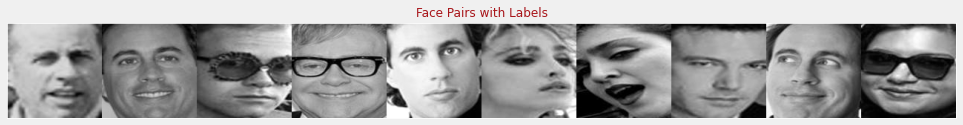

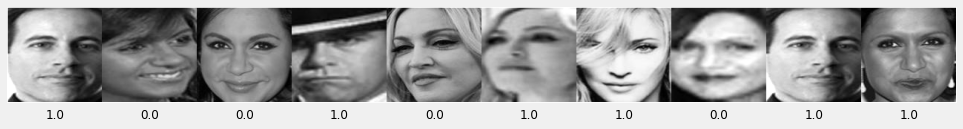

In [ ]:
pair_indices = np.random.choice(len(train_pairs), 10, replace=False)
visualize_pairs(train_pairs[pair_indices, 0],
                train_pairs[pair_indices, 1], 
                train_ys[pair_indices], 
                title="Face Pairs with Labels", n = 10)

**We can observe that pairs with same images have label 1 and dissimilar images have label 0.** 

# Building the Siamese Network

We will be using transfer learning using MobileNetV2 for our convolutional feature extractor. Hence we first load and see the architecture of the same. 

In [ ]:
feature_extractor_temp = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_extractor_temp.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

#### 1. Building Base Network 

Since, the first few layers of the MobileNet extract basic features that would be used to extract meaningful features, we would freeze the weights of initial layers and only train the layers that are towards the end.

In [ ]:
# Get feature extractor
def get_feature_extractor():
    feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False)
    for layer in feature_extractor.layers:
        if layer.name.startswith('block_13'):
            break
        layer.trainable = False
    return feature_extractor

In [143]:
# Method to create the Base network
def build_base_network(name="base_network"):
    # Initialize feature extractor
    feature_extractor = get_feature_extractor()
    input = Input(shape=IMAGE_SHAPE, name="base_input")
    x = feature_extractor(input)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dropout(0.6)(x)
    x = Dense(units=150, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(units = 128)(x)
    normalizer = Lambda(lambda x: K.l2_normalize(x, axis=1), name="L2_norm")
    x = normalizer(x)
    return Model(inputs=input, outputs=x, name=name)

Let's see how our base network or the sister network looks like.

In [144]:
base_network = build_base_network("base_network")
base_network.summary()

Model: "base_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_17  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_34 (Dropout)        (None, 1280)              0         
                                                                 
 dense_34 (Dense)            (None, 150)               192150    
                                                                 
 dropout_35 (Dropout)        (None, 150)              

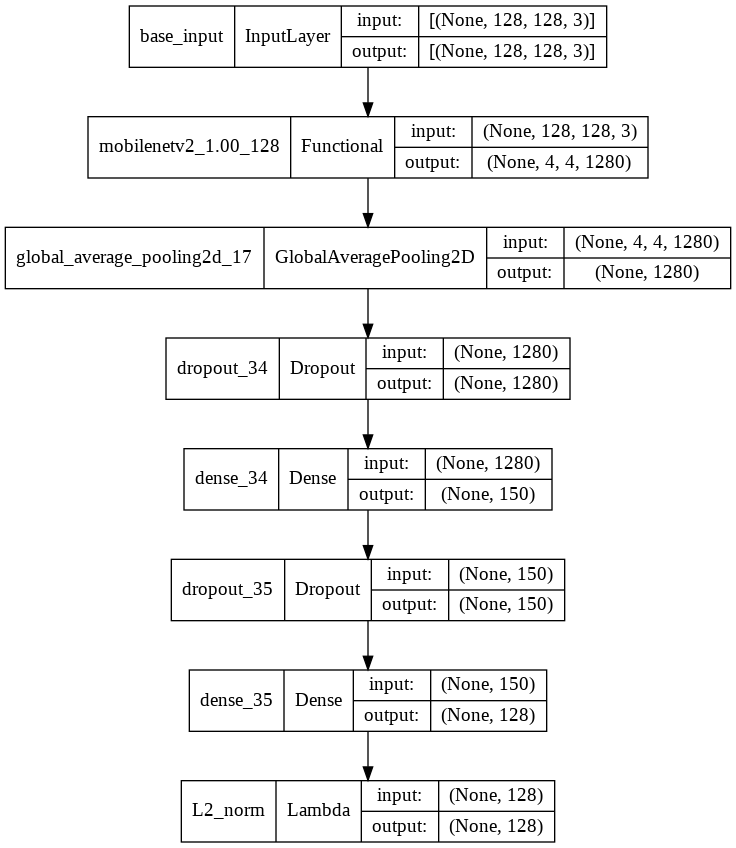

In [145]:
plot_model(base_network, show_shapes=True)

#### 2. Defining the euclidean distance function to compute distance between two vectors

In [146]:
# Function computes the euclidean distance between two vectors
def euclidean_distance(vectors):
    vec1, vec2 = vectors
    squared_sum = K.sum(K.square(vec1 - vec2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(squared_sum, K.epsilon()))

def eucl_dist_outshape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

#### 3. Combine inputs, base network and output layer to create the siamese network 

In [147]:
# Creates the entire network
def build_siamese_network():
    base_network = build_base_network("base_network")

    input_a = Input(shape=IMAGE_SHAPE, name="input_a")
    output_vector_a = base_network(input_a) 

    input_b = Input(shape=IMAGE_SHAPE, name="input_b")
    output_vector_b = base_network(input_b)

    output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_outshape)([output_vector_a, output_vector_b])
    model = Model(inputs=[input_a, input_b], outputs=output)
    return model


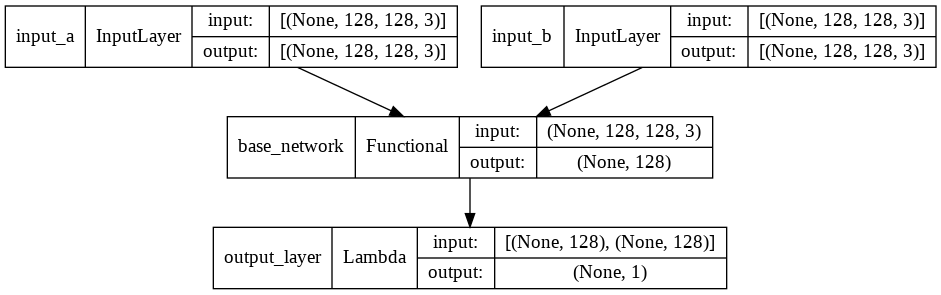

In [169]:
tf.random.set_seed(4)
siamese_model = build_siamese_network()
plot_model(siamese_model, show_shapes=True)

# Creating the loss function

Now, we define the contrastive loss for training the siamese network. 

In [149]:
# Wrapper function to return the contastive loss function with margin
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        pred_square = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * pred_square + (1-y_true)*margin_square)
    return contrastive_loss 

# Training the Network

Compiling the model for training and choosing the optimizer with suitable learning rate.

In [170]:
opt = tf.keras.optimizers.Adam(learning_rate=8e-5)
siamese_model.compile(loss=contrastive_loss_with_margin(margin=1.05), optimizer=opt)

Defining a custom callback for early stopping of the model.

In [171]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, loss_cutoff):
        self.loss_cutoff = loss_cutoff

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs['loss']
        val_loss = logs['val_loss']
        # if ((val_loss-train_loss) > 0.02 and (train_loss < self.loss_cutoff)) or val_loss < 0.36:
        if(train_loss < self.loss_cutoff and val_loss < self.loss_cutoff):
            self.model.stop_training = True

In [172]:
early_stopping_callback = MyCallback(0.04)

Training the siamese model

In [173]:
history = siamese_model.fit([train_pairs[:, 0], train_pairs[:,1]], train_ys,
                    epochs=200, batch_size=32,
                    validation_data=([val_pairs[:,0], val_pairs[:,1]], val_ys), validation_batch_size=32, callbacks=[early_stopping_callback])

Epoch 1/200
52/52 [==============================] - 15s 126ms/step - loss: 0.6992 - val_loss: 0.2643
Epoch 2/200
52/52 [==============================] - 5s 91ms/step - loss: 0.4685 - val_loss: 0.3039
Epoch 3/200
52/52 [==============================] - 5s 88ms/step - loss: 0.3664 - val_loss: 0.3373
Epoch 4/200
52/52 [==============================] - 5s 88ms/step - loss: 0.3238 - val_loss: 0.3563
Epoch 5/200
52/52 [==============================] - 5s 91ms/step - loss: 0.3052 - val_loss: 0.3648
Epoch 6/200
52/52 [==============================] - 5s 93ms/step - loss: 0.2921 - val_loss: 0.3753
Epoch 7/200
52/52 [==============================] - 5s 91ms/step - loss: 0.2863 - val_loss: 0.3836
Epoch 8/200
52/52 [==============================] - 5s 91ms/step - loss: 0.2795 - val_loss: 0.3872
Epoch 9/200
52/52 [==============================] - 5s 88ms/step - loss: 0.2799 - val_loss: 0.3905
Epoch 10/200
52/52 [==============================] - 5s 89ms/step - loss: 0.2748 - val_loss: 0.38

# Evaluating the model

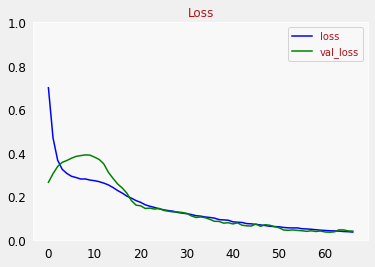

In [174]:
def plot_metrics(metric_name, title, ylim=2):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_'+metric_name)
    plt.legend()

plot_metrics('loss', 'Loss', ylim=1)

In [175]:
def convert_distance_to_ys(y_pred):
    return y_pred.ravel() < 0.5
    
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distance'''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [176]:
train_loss = siamese_model.evaluate(x=[train_pairs[:,0], train_pairs[:,1]], y = train_ys)
val_loss = siamese_model.evaluate(x=[val_pairs[:,0], val_pairs[:,1]], y = val_ys)
 
y_pred_train = siamese_model.predict([train_pairs[:, 0], train_pairs[:,1]])
train_accuracy = compute_accuracy(train_ys, y_pred_train)

y_pred_val = siamese_model.predict([val_pairs[:, 0], val_pairs[:,1]])
val_accuracy = compute_accuracy(val_ys, y_pred_val)

print("Training Loss = {} \tValidation Loss ={}".format(train_loss,val_loss))
print("Train Accuracy = {} \tValidation accuracy={}".format(train_accuracy, val_accuracy))

4/4 [==============================] - 0s 49ms/step - loss: 0.0398
Training Loss = 0.0027803084813058376 	Validation Loss =0.0398486964404583
Train Accuracy = 1.0 	Validation accuracy=0.95


In [177]:
def evaluate_model(model, pairs, y_true):
    loss = model.evaluate(x=[pairs[:,0], pairs[:,1]], y = y_true)
    y_pred = model.predict([pairs[:, 0], pairs[:,1]])
    accuracy = compute_accuracy(y_true, y_pred)
    print("Loss: {}\tAccuracy:{}".format(loss, accuracy))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95        50
         1.0       0.98      0.92      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



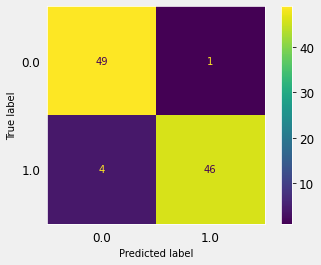

In [178]:
pred_class_val = convert_distance_to_ys(y_pred_val)
ConfusionMatrixDisplay.from_predictions(val_ys, pred_class_val)
print(classification_report(val_ys, pred_class_val))

# Visualizing the results

## Run the model on training pairs to see its output

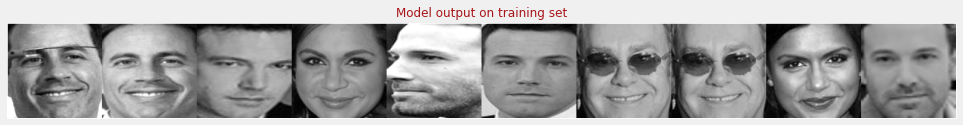

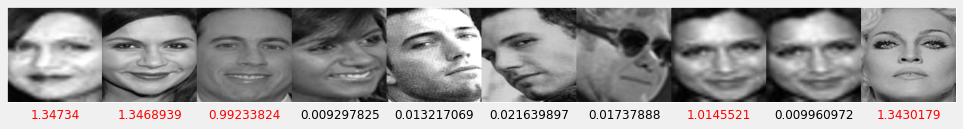

In [179]:
# Use the plotting utilities
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
visualize_pairs(train_pairs[:,0][indexes], train_pairs[:,1][indexes],train_ys[indexes], y_pred_train[indexes], "Model output on training set", 10)

## Run the model on validation pairs to see its output

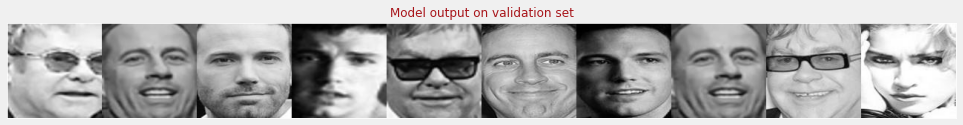

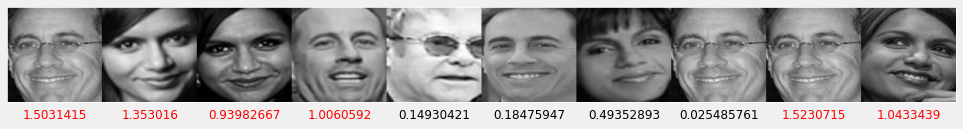

In [180]:
# Use the plotting utilities
y_pred_val = np.squeeze(y_pred_val)
indexes = np.random.choice(len(y_pred_val), size=10, replace=False)
visualize_pairs(val_pairs[:,0][indexes], val_pairs[:,1][indexes],val_ys[indexes], y_pred_val[indexes], "Model output on validation set", 10)

# Saving the model for future use

## Save the model

In [181]:
siamese_model.save('/content/drive/MyDrive/AI Project/siamese_models/celebrity_data_models/mobilenet_siamese_95Acc')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI Project/siamese_models/celebrity_data_models/mobilenet_siamese_95Acc/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Load and check if model is saved correctly

In [182]:
model = tf.keras.models.load_model('/content/drive/MyDrive/AI Project/siamese_models/celebrity_data_models/mobilenet_siamese_95Acc', 
                                   custom_objects={'contrastive_loss':contrastive_loss_with_margin(1.05)}
                                                        
)

print("Validation set metrics: ")
evaluate_model(model, val_pairs, val_ys)

Validation set metrics: 
4/4 [==============================] - 3s 62ms/step - loss: 0.0398
Loss: 0.0398486964404583	Accuracy:0.95


### Run the loaded model on training pairs to see its output

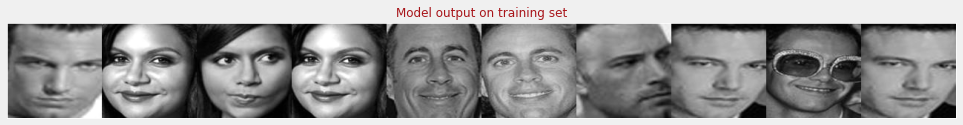

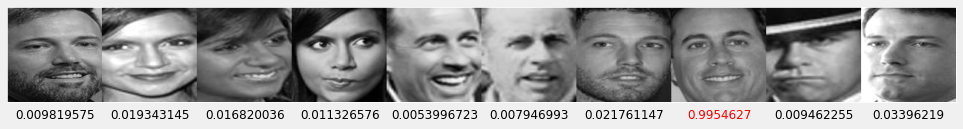

In [183]:
# Use the plotting utilities
y_pred_train = model.predict([train_pairs[:, 0], train_pairs[:,1]])
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
visualize_pairs(train_pairs[:,0][indexes], train_pairs[:,1][indexes],train_ys[indexes], y_pred_train[indexes], "Model output on training set", 10)

### Run the loaded model on validation pairs to see its output

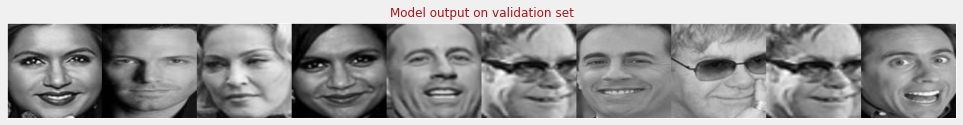

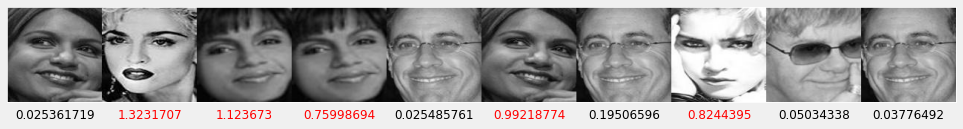

In [184]:
# Use the plotting utilities
y_pred_val = model.predict([val_pairs[:, 0], val_pairs[:,1]])
y_pred_val = np.squeeze(y_pred_val)
indexes = np.random.choice(len(y_pred_val), size=10, replace=False)
visualize_pairs(val_pairs[:,0][indexes], val_pairs[:,1][indexes],val_ys[indexes], y_pred_val[indexes], "Model output on validation set", 10)